In [1]:
import pandas as pd 
import numpy as np 
import os, io
import subprocess
import matplotlib.pyplot as plt 
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from platform import python_version
from astropy.visualization import ZScaleInterval


In [3]:
print(python_version())

3.7.5


In [54]:
def bash_command(cmd, print_output=True):
    # For ubuntu terminal but may work on Mac (let me know if it doesnt!)
    # Issue command to terminal after loading a bashrc or bashprofile
    print(f"Running Command: {cmd}")
    output = subprocess.check_output(["/bin/bash", "-i", "-c", cmd])
    if print_output:
        return output


def format_obs_id_output(output):
    # The shell output is in bytes, convert to string
    string = output.decode("utf-8")
    # Split string into rows
    block = string.split("\n")[4:]
    # Take out the octothorpe so it isnt counted as na extra column
    block[
        0
    ] = "obsid  sepn   inst grat   time    obsdate      piname                                               target"
    # Convert output to pandas dataframe
    df = pd.read_csv(io.StringIO("\n".join(block)), delim_whitespace=True)

    return df


def locate(ra, dec, radius=1):
    # radius is set to the default of 1 arcmin
    # sepn is also in arcmin
    return bash_command(
        "ciao_init; find_chandra_obsid %s %s radius=%s" % (ra, dec, radius)
    )


def download(obsid):
    # If more than one id is passed from pandas dataframe
    if type(obsid) == pd.core.series.Series:
        # Get string of comma separated values without brackets
        obsid = str(list(obsid))[1:-1].replace(" ", "")
    # Download
    out = bash_command("ciao_init; download_chandra_obsid %s" % obsid)
    return out.decode("utf-8").split("\n")


def reprocess(obsid, outdir):
    # Create new folder with data_reduced files
    out = bash_command("ciao_init; chandra_repro %s outdir=%s" % (obsid, outdir))
    return out


def cleanup(obsid):
    # Remove non-reduced folder
    out = bash_command("rm -r %s" % obsid)
    return out


def estimate_nh(ra, dec):
    # From log: Using map h1_nh_HI4PI.fits'

    # Previous 'nh' versions used different maps to derive NH values.
    # They are the (a) HI map by Kalberla et al. 2005, Astronomy & Astrophysics, 440, 775, known as the Leiden/Argentine/Bonn (LAB) survey and
    # (b) the HI map by Dickey & Lockman (DL), 1990, Ann. Rev. Ast. Astr. 28, 215. They are still released with the software for back compatibility;
    # however, the HI4PI map outperforms the LAB and DL maps

    output = bash_command("heainit; nh equinox=2000 ra=%s dec=%s" % (ra, dec))
    log = output.decode("utf-8").split("\n")

    # Get table and convert to pandas
    begin = 12
    far_end = 30
    return_found = 2
    for i in range(begin - 1, far_end):
        if log[i].find("nH") == return_found:
            end = i
            break
    nh_table = log[begin - 1 : end - 1]

    nh_df = pd.read_csv(io.StringIO("\n".join(nh_table)), delim_whitespace=True)

    # Take the nH value that was closest to source
    min_dist = np.min(nh_df["Dist"])  # in degrees
    nh = nh_df["nH"][nh_df["Dist"] == min_dist]
    print(f"Arcmin from source:{min_dist * 60}")

    # absmodel = xsphabs.abs1
    # need to convert to these units which is 10^22 cm^-2
    # https://cxc.cfa.harvard.edu/sherpa/ahelp/xsphabs.html
    nh_xsphabs = nh / 1e22
    
    return str(np.array(nh_xsphabs))[1:-1]

def get_coords(obsid,ra,dec):
    fname = "%s_repro/*_repro_evt2.fits" % (obsid)
    
    out = bash_command(
        f"ciao_init; dmcoords {fname} ra='{ra}' dec='{dec}'"
    )
    return out

def source_flux(obsid, ra, dec):
    fname = "%s_repro/*_repro_evt2.fits" % (obsid)
    # Note: need to fix leading 0 issue - i forgot what this issue was lol
    # outname = '%s_flux/' % obsid
    outname = "flux_test"
    # out = bash_command('ciao_init; srcflux infile=%s pos=%s %s outroot=%s' % (fname,ra,dec,outname))
    out = bash_command(
        f"ciao_init; srcflux infile={fname} pos='{ra} {dec}' outroot={outname} clobber=yes absparam='abs1.nH={estimate_nh(ra,dec)}' psfmethod=arfcorr conf=0.997 bands='0.3:7:2.3'"
    )
    return out


In [3]:
# A18 SOURCE
c = SkyCoord("01h00m59.7024s" "-72d37m13.728s", unit=(u.hourangle, u.deg))
ra = str(c.ra.deg)
dec = str(c.dec.deg)

In [4]:
out = locate(ra,dec,5)

Running Command: ciao_init; find_chandra_obsid 15.248759999999997 -72.62047999999999 radius=5


In [5]:
df = format_obs_id_output(out)
df

,obsid,sepn,inst,grat,time,obsdate,piname,target
0,3525,37.9,ACIS-S,NONE,7.6,2003-02-01,Calibration,"E0102-72[S5,-120,-17.29,0,0]"
1,11821,15.1,ACIS-S,NONE,28.2,2010-12-09,Predehl,HFPK 334
2,14668,21.9,ACIS-I,NONE,49.4,2013-01-02,Zezas,Deep Field 05


In [22]:
# Download Multiple or Single
download(df['obsid'])

['CIAO configuration is complete... ',
 'CIAO 4.12 Monday, November 25, 2019',
 '  bindir      : /home/bethany/ciao-4.12/bin',
 '  CALDB       : 4.9.1',
 'Downloading files for ObsId 3525, total size is 45 Mb.',
 '',
 '  Type     Format      Size  0........H.........1  Download Time Average Rate',
 '  ---------------------------------------------------------------------------',
 '  vv       pdf        18 Mb  ####################            2 s  7735.1 kb/s',
 '  evt1     fits       17 Mb  ####################            2 s  10529.3 kb/s',
 '  evt2     fits        3 Mb  ####################            1 s  2559.4 kb/s',
 '  asol     fits        2 Mb  ####################            1 s  1882.9 kb/s',
 '  bias     fits      495 Kb  ####################          < 1 s  503.5 kb/s',
 '  bias     fits      447 Kb  ####################          < 1 s  463.5 kb/s',
 '  bias     fits      440 Kb  ####################          < 1 s  444.8 kb/s',
 '  bias     fits      438 Kb  ################

In [23]:
for obsid in df["obsid"]:
    # Reduce
    r = reprocess("%s" % obsid, "%s_repro" % obsid)
    print(r)

    # If Reprocess was successful
    if os.path.isdir("%s_repro" % obsid):
        # Delete Un Processed Data
        c = cleanup(obsid)
    print(c)

b"CIAO configuration is complete... \nCIAO 4.12 Monday, November 25, 2019\n  bindir      : /home/bethany/ciao-4.12/bin\n  CALDB       : 4.9.1\n\nRunning chandra_repro\nversion: 03 April 2020\n\n\nProcessing input directory '/home/bethany/Desktop/ChandraXrayBinaries/Data/3525'\n\nResetting afterglow status bits in evt1.fits file...\n\nRunning the destreak tool on the evt1.fits file...\n\nRunning acis_build_badpix and acis_find_afterglow to create a new bad pixel file...\n\nRunning acis_process_events to reprocess the evt1.fits file...\nFiltering the evt1.fits file by grade and status and time...\nApplying the good time intervals from the flt1.fits file...\nThe new evt2.fits file is: /home/bethany/Desktop/ChandraXrayBinaries/Data/3525_repro/acisf03525_repro_evt2.fits\n\nUpdating the event file header with chandra_repro HISTORY record\nCreating FOV file...\nSetting observation-specific bad pixel file in local ardlib.par.\n\nCleaning up intermediate files\n\nWARNING: Observation-specific b

In [6]:
obsids = df['obsid']
source_flux(obsids[1],ra,dec)

Running Command: heainit; nh equinox=2000 ra=15.248759999999997 dec=-72.62047999999999
Arcmin from source:1.776
Running Command: ciao_init; srcflux infile=11821_repro/*_repro_evt2.fits pos='15.248759999999997 -72.62047999999999' outroot=flux_test clobber=yes absparam='abs1.nH=0.644' psfmethod=arfcorr


KeyboardInterrupt: 

In [52]:
im = fits.open('142_repro/hrcf00142_repro_evt2.fits')

#wcs = WCS(im[0].header)

source_x,source_y = WCS(im[2].header).all_world2pix(ra,dec,0)

TypeError: Cannot cast array data from dtype('<U18') to dtype('float64') according to the rule 'safe'

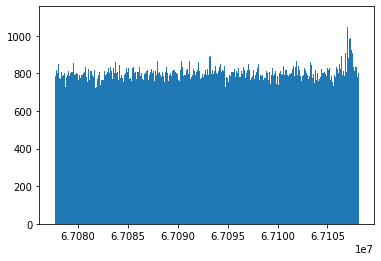

In [23]:
# Considering removing not good time intervals? 
# https://sarahspolaor.faculty.wvu.edu/files/d/c5375159-33b3-401a-9664-d21ce3302d9a/project_2.pdf
    
data = im[1].data

time = data['time']

plt.hist(time,bins=1000);

In [30]:
data

FITS_rec([(67077661.08163711, 47, 10, 2, 371, 2378,  238,  415, 2222,  342,  2682, 12149,  2681, 12149,  2680, 12149,  9858.419 , 16047.192, 15287.393, 22974.926,  93.21875  ,  80, 131, 5966, 0, [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
          (67077661.09794962, 49, 49, 1, 248,  417,   19,   41,  520,  166, 12716, 12586, 12719, 12583, 12718, 12583, 16642.777 , 23447.22 , 23525.107, 17236.627,  11.0234375,  10,  17, 1411, 0, [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
          (67077661.13377775, 34, 47, 2, 521, 3502,  378,  116, 2316, 1694, 12258,  8824, 12266,  8824, 12265,  8824, 18979.33  , 20471.096, 20886.701, 14524.499, 133.23438  , 114, 152, 8527, 0, [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0

In [35]:
len(data['x'])

806218

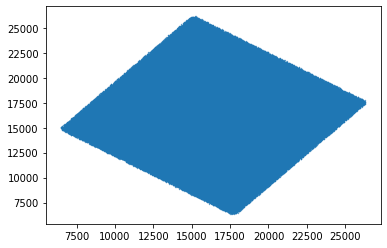

In [29]:
plt.scatter(data['x'],data['y'],s=.1)

In [36]:
hist, x_edges, y_edges = np.histogram2d(data['x'],data['y'],bins=400)

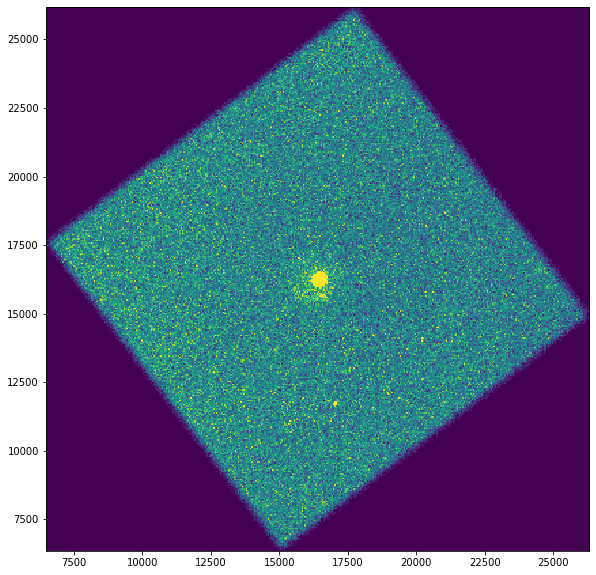

In [41]:
fig = plt.figure(figsize=(10,10))

interval = ZScaleInterval()
vmin,vmax = interval.get_limits(hist)

plt.imshow(hist.T,extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],vmin=vmin,vmax=vmax)

In [57]:
get_coords(obsids[1],ra,dec)

Running Command: ciao_init; dmcoords 11821_repro/*_repro_evt2.fits ra='15.248759999999997' dec='-72.62047999999999'


b'CIAO configuration is complete... \nCIAO 4.12 Monday, November 25, 2019\n  bindir      : /home/bethany/ciao-4.12/bin\n  CALDB       : 4.9.1\ndmcoords>: \n'

In [58]:
from ciao_contrib.runtool import *

ModuleNotFoundError: No module named 'ciao_contrib'